<center>
<h1>
<b>Name: Nader M. Elhadedy</b><br>
<b>Task: Recommender Systems</b>
</h1>
</center>


---

<center>
<h1><b>(1) ... Recommend Top 5 movies by a given title ...</b></h1>
</center>

# This follows what is called **Item-based Collaborative Filtering**

> This filtration strategy is based on the combination of the user’s behavior and comparing and contrasting that with other users’ behavior in the database. The history of all users plays an important role in this algorithm. There are multiple ways to implement collaborative filtering but the main concept to be grasped is that in collaborative filtering multiple user’s data influences the outcome of the recommendation. and doesn’t depend on only one user’s data for modeling. <br><br> In other words, the concept in this case is to find similar movies instead of similar users and then recommending similar movies to that ‘A’ has had in his/her past preferences. This is executed by finding every pair of items that were rated/viewed/liked/clicked by the same user, then measuring the similarity of those rated/viewed/liked/clicked across all user who rated/viewed/liked/clicked both, and finally recommending them based on similarity scores.

# **About Data**

This dataset describes 5-star rating from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

The data are contained in the files `movies.csv` and `ratings.csv`.

- All ratings are contained in the file `ratings.csv` with columns (userId, movieId, rating, timestamp).
- Movie information is contained in the file `movies.csv` with columns (movieId, title, genres).

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from io import BytesIO
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from zipfile import ZipFile
from urllib.request import urlopen

In [ ]:
plt.style.use('ggplot')

# Load Dataset

In [ ]:
data_path = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
r = urlopen(data_path)
zipfile = ZipFile(BytesIO(r.read()))

zipfile.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/tags.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/movies.csv']

In [ ]:
ratings_df = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'))
print('Shape of rating data:', ratings_df.shape)
ratings_df.head()

Shape of rating data: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies_df = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))
print('Shape of movies data', movies_df.shape)
movies_df.head()

Shape of movies data (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Explore Data

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
# unique users
np.unique(ratings_df['userId']).shape

(610,)

In [ ]:
# unique movies
np.unique(movies_df['movieId']).shape

(9742,)

# Create new dataframe

> ### To make dataset look better, we will set unique users agaist unique movies and show their ratings.

In [ ]:
final_dataset = ratings_df.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head(10)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.5,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.5,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.5,NaN,NaN,NaN,3.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.5,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,4.5,NaN,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.5,3.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_dataset.shape

(9724, 610)

> ### There are many movies that weren't rated by users, so, there are many NaN values so will be imputed.

> As we know that not all users watch all the movies, we can expect a lot of missing values. We will have to fill those missing observations with 0s since we are going to perform linear algebra operations (calculating distances between vectors).

In [ ]:
final_dataset.fillna(0, inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


> ### To make the data valuable and credible for good recommendation, we will put limits for the number of votes for a movie to be well rated and the number of votes for a user to trust his rating.

In [ ]:
# count number of votes for each movie
ratings_df.groupby('movieId')['rating'].agg('count')

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [ ]:
# count number of movies rated by a user
ratings_df.groupby('userId')['rating'].agg('count')

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64

In [ ]:
users_per_movie_count = ratings_df.groupby('movieId')['rating'].agg('count')
votes_per_user_count = ratings_df.groupby('userId')['rating'].agg('count')

# Visualize the number of votes for each movie

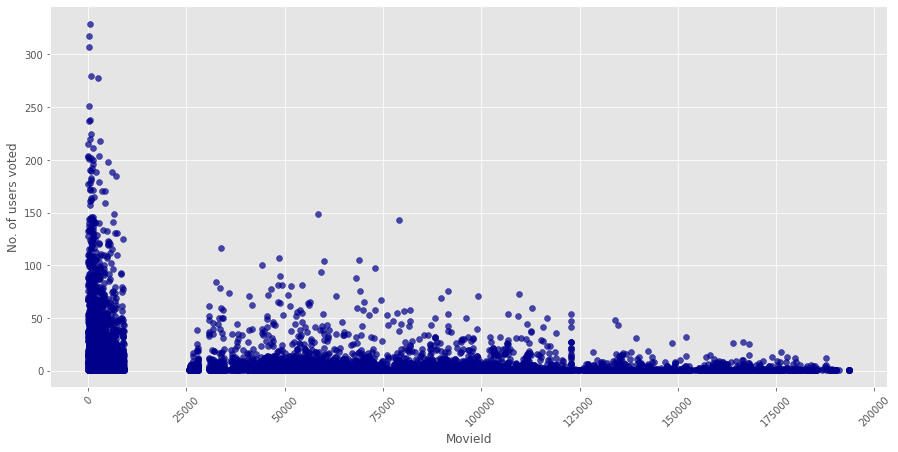

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(users_per_movie_count.index, users_per_movie_count.values, color='darkblue', alpha=0.7)
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.xticks(rotation=45)
plt.show()

> ### We will put a threshold for the number of votes on a movie to be accepted after getting **10** votes.

In [ ]:
N_VOTES_THRESHOLD = 10
final_dataset = final_dataset.loc[users_per_movie_count[users_per_movie_count >= N_VOTES_THRESHOLD].index, :]

# Visualize the number of movies rated by each user

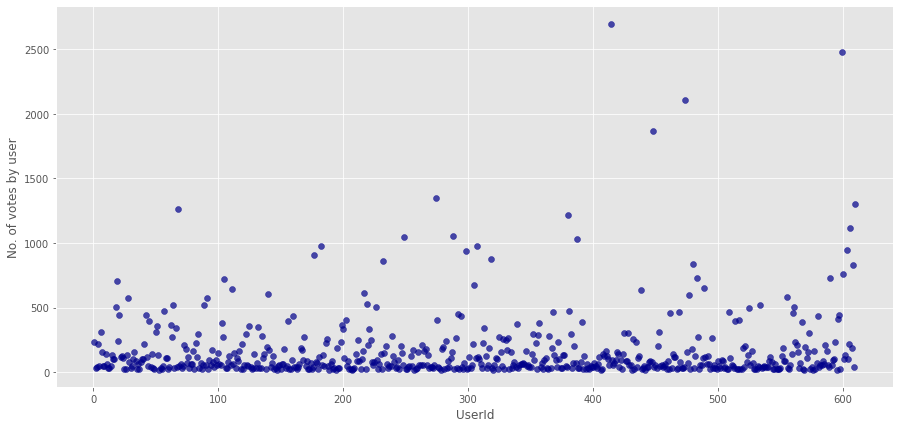

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(votes_per_user_count.index, votes_per_user_count.values, color='darkblue', alpha=0.7)
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

> ### We will put a threshold for the number of movies rated by a user for his rating to be accepted after getting **25** votes.

In [ ]:
N_RATES_THRESHOLD = 25
final_dataset = final_dataset.loc[:, votes_per_user_count[votes_per_user_count >= N_RATES_THRESHOLD].index]

In [ ]:
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,36,38,39,40,41,42,43,...,565,566,567,570,571,572,573,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,596,597,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,...,0.0,0.0,3.5,4.0,0.0,4.0,5.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.5,0.0,3.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


> ### The dataset contains many unvoted movies by many users as discussed above, so we will convert the dataset to a compressed sparse matrix to remove sparsity and simplify computations.

In [ ]:
clean_dataset = csr_matrix(final_dataset.values)
# reset the default index instead of the MultiIndex
final_dataset.reset_index(inplace=True)

In [ ]:
print(clean_dataset)

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 25)	3.0
  (0, 29)	5.0
  (0, 30)	3.0
  (0, 31)	3.0
  (0, 36)	5.0
  (0, 39)	5.0
  (0, 40)	3.0
  (0, 41)	4.0
  (0, 42)	5.0
  (0, 45)	3.0
  (0, 48)	3.0
  (0, 51)	5.0
  (0, 56)	5.0
  (0, 57)	4.0
  (0, 59)	4.0
  (0, 61)	2.5
  (0, 64)	5.0
  :	:
  (2266, 537)	4.5
  (2267, 55)	3.5
  (2267, 89)	3.0
  (2267, 138)	0.5
  (2267, 187)	4.5
  (2267, 223)	4.5
  (2267, 343)	0.5
  (2267, 373)	4.5
  (2267, 462)	2.0
  (2267, 463)	4.0
  (2267, 509)	2.0
  (2267, 524)	5.0
  (2267, 533)	3.5
  (2268, 24)	5.0
  (2268, 55)	4.0
  (2268, 89)	5.0
  (2268, 208)	2.5
  (2268, 222)	4.5
  (2268, 223)	5.0
  (2268, 272)	5.0
  (2268, 295)	4.0
  (2268, 302)	1.0
  (2268, 343)	3.0
  (2268, 462)	3.5
  (2268, 524)	4.0


# **Making the movie recommendation system model**

## - One of the algorithms that is a very basic common approach for implementing the recommendation system is **Nearest Neighbor algorithm**.

* ## I used NearestNeighbors algorithm from Sklearn library which is Unsupervised learner for implementing neighbor searches.
* ## As a metric for measuring distances, I used `Cosine Similarity` which is the measure of calculating the difference of angle between two vectors.
* ## As a searching algorithm, I used the `Brute Force` algorithm.
 * The simplest version of the kNN algorithm is the 'Brute
Force' implementation and consists of three stages. The
first stage is to calculate all of the `distances' from each
query point to every reference point in the training set. The
second stage is to sort these distances and select the k
objects that are the closest from which the third and final
stage of classification can be performed.
 * More formally,
KNN finds the K closest (or most similar) points to a
query point among N points in a d- dimensional attribute
(or feature) space.

# **`It works as follows:`**

### - Movie Recommendation using the KNN model with Input as Movie Name and Number of movies you want to get recommended. Reshaping model in such a way that each movie has n-dimensional rating space where n is total number of users who could rate.
### - We will train the KNN model in order to find the closely matching similar movies to the movie we give as input and we recommend the top movies which would more closely align to the movie we have given.
### - KNN algorithm is used to determine the corresponding similar movie or a user based on `cosine similarity`. K value is defined and desired number of nearest neighboring movies/users are returned.

In [ ]:
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(clean_dataset)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

# **Define Recommendation Functions**

In [ ]:
def suggest_movie_titles(movie_name, n_top_movies):
    """
    Suggest specific number of possible movies when misspelling occurs.

    Parameters
    ----------
    movie_name: str
        Represents the name of the movie to be used in the function.

    n_top_movies: int
        Represents the number of movies to be suggest.

    Returns
    -------
    df: data frame
        Describes suggested movie titles to try entering again.
    """
    temp = ''
    movies_list = movies_df.title.tolist()
    case_insensitive_movies_list = [i.lower() for i in movies_list]
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie_name:
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          temp_output = possible_movies[:n_top_movies]
          indices = [case_insensitive_movies_list.index(i) for i in temp_output if i in temp_output]
          output = [movies_list[i] for i in indices]
          return pd.DataFrame(output, index=range(1,n_top_movies+1), columns=['Suggested to try again'])
      out.sort()
      possible_movies = out.copy()
    temp_output = possible_movies[:n_top_movies]
    indices = [case_insensitive_movies_list.index(i) for i in temp_output if i in temp_output]
    output = [movies_list[i] for i in indices]
    return pd.DataFrame(output, index=range(1,n_top_movies+1), columns=['Suggested to try again'])

In [ ]:
def get_movies_recommendation(movie_name, n_top_movies):
    """
    Recommend specific number of top movies based on movie name.

    Parameters
    ----------
    movie_name: str
        Represents the name of the movie to be used in the function.
        It must be found in the database to recommend other movies.

    n_top_movies: int
        Represents the number of movies to be recommended.

    Returns
    -------
    alert, df: data frame
        Describes top recommended movies.
        alert: when movie_name is not found in database and df: otherwise.
    """
    movie_list = movies_df[movies_df['title'].str.contains(movie_name)]
    #alert = "No movies found. Please enter another movie title"
    if len(movie_list):        
        movie_idx = movie_list.iloc[0]['movieId']
        rates = final_dataset[final_dataset['movieId'] == movie_idx]
        if len(rates):
          movie_idx = rates.index[0]
        else:
          return suggest_movie_titles(movie_name, n_top_movies)

        distances , indices = model.kneighbors(clean_dataset[movie_idx], n_neighbors=n_top_movies+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies_df[movies_df['movieId'] == movie_idx].index
            recommend_frame.append({'Movie Title':movies_df.iloc[idx]['title'].values[0]})
        df = pd.DataFrame(recommend_frame, index=range(1,n_top_movies+1))
        return df
    else:
        return suggest_movie_titles(movie_name, n_top_movies)

# Call the function to get recommendations

In [ ]:
get_movies_recommendation('Evil Dead', 5)

,Movie Title
1,Escape from New York (1981)
2,Re-Animator (1985)
3,Bubba Ho-tep (2002)
4,"Evil Dead, The (1981)"
5,Army of Darkness (1993)


In [ ]:
get_movies_recommendation('Manhattan', 5)

,Movie Title
1,Bullets Over Broadway (1994)
2,Everyone Says I Love You (1996)
3,Notorious (1946)
4,Manhattan (1979)
5,Crimes and Misdemeanors (1989)


In [ ]:
get_movies_recommendation('Iron Man', 5)

,Movie Title
1,Avatar (2009)
2,Iron Man 2 (2010)
3,"Avengers, The (2012)"
4,WALL·E (2008)
5,"Dark Knight, The (2008)"


> ### Misspell movie title

In [ ]:
get_movies_recommendation('irons mans', 5)

,Suggested to try again
1,3-Iron (Bin-jip) (2004)
2,Aces: Iron Eagle III (1992)
3,Generation Iron 2
4,Gridiron Gang (2006)
5,"Invincible Iron Man, The (2007)"


### Recommendations are quiet good and it's working well but we can also test the performance or the quality of the recommendation by splitting the data at first then using a metric such as MSE or RMSE.

---

<center>
<h1><b>(2) ... Estimate the rating of a movie based on a user behaviour ...</b></h1>
</center>

# This follows what is called **User-based Collaborative Filtering**

> It's a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. <br><br> The basic idea here is to find users that have similar past preference patterns as the user ‘A’ has had and then recommending him or her items liked by those similar users which ‘A’ has not encountered yet.

# Construct Dataset

In [ ]:
df = pd.merge(ratings_df, movies_df, on='movieId').drop(['timestamp', 'genres'], axis=1)

# Explore Data

In [ ]:
df.shape

(100836, 4)

In [ ]:
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


# Filter Data

> We need to filter our movies as we did before, based on the number of ratings on a movie.

In [ ]:
# measure number of reviews before transformation as a check
len(df[df['movieId'] == 10])

132

In [ ]:
# apply count function on each rating for each movie
df['movie_reviews'] = df.groupby(['movieId'])['rating'].transform('count')

In [ ]:
df.head()

,userId,movieId,rating,title,movie_reviews
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [ ]:
df.loc[df['movieId'] == 10, 'movie_reviews'] # 132 reviews when movieId=10, as expected

27378    132
27379    132
27380    132
27381    132
27382    132
        ... 
27505    132
27506    132
27507    132
27508    132
27509    132
Name: movie_reviews, Length: 132, dtype: int64

# Visualize Data to choose threshold value

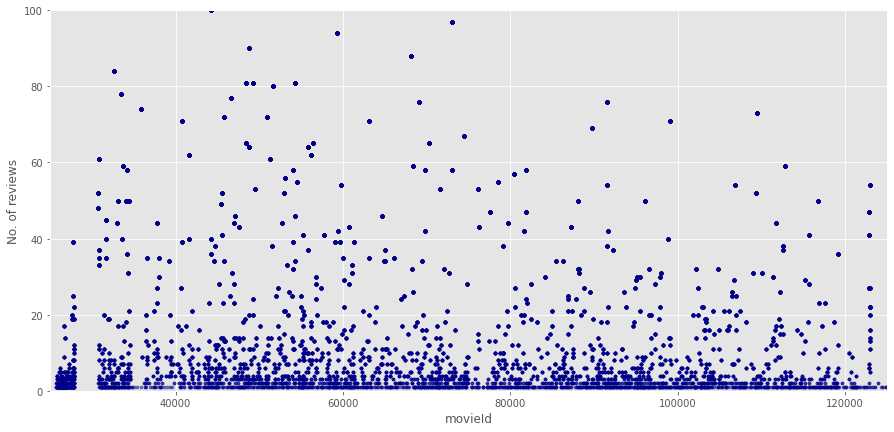

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(df.movieId, df.movie_reviews, color='darkblue', alpha=0.5, s=10)
plt.xlabel('movieId')
plt.ylabel('No. of reviews')
plt.xlim([25000, 125000])
plt.ylim([0, 100])
plt.show()

> So, we will put a threshold of **10 reviews** on a movie to be accepted.

In [ ]:
N_REVIEWS_THRESHOLD = 10
final_df = df[df.movie_reviews >= N_REVIEWS_THRESHOLD].drop(['title', 'movie_reviews'], axis=1)
final_df.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


### Our movie rating prediction is based on a specific user, so, we will choose any userId to be used on the model for later. Let it be the **most voting user** with the most number of making reviews.

In [ ]:
users_grouped = final_df.groupby('userId')['rating'].agg('count')
max_reviews_user = users_grouped.max()

In [ ]:
# target user Id
vip_user_id = users_grouped[final_df.groupby('userId')['rating'].agg('count') == max_reviews_user].index[0]

In [ ]:
# show user preferences
final_df[final_df.userId == vip_user_id].head()

,userId,movieId,rating
146,414,1,4.0
251,414,3,4.0
336,414,6,3.0
511,414,47,4.0
717,414,50,5.0


# **Making the movie rating prediction system model**

## - For this system, we will use **Surprise**.

* ### Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

## - From Surprise, we will use **NMF** as a predicting algorithm.

* ### NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization.

In [ ]:
!pip install surprise

In [ ]:
from surprise import NMF
from surprise import Reader
from surprise import Dataset

## - From Surprise, we will also use:

* ### **`Reader`** : A class surprise use to parse a file containing ratings.
 * It takes **rating_scale**  as input which is the raing scale in the dataset that is (1,5) by default.
* ### **`Dataset`** : The dataset module defines the Dataset class and other subclasses which are used for managing datasets from which we will use a class method called load_from_df which takes two inputs:

 * **df(Dataframe)**: The dataframe containing the ratings. It must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings, in this order.
  * **reader(Reader)**: A reader to read the file. Only the rating_scale field needs to be specified.
        


In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_df, reader)

In [ ]:
data.raw_ratings[:5]

[(1, 1, 4.0, None),
 (5, 1, 4.0, None),
 (7, 1, 4.5, None),
 (15, 1, 2.5, None),
 (17, 1, 4.5, None)]

# Show the implementation steps

> ### 1) First, we should gather the movies that the user had not seen before so that the prediction is logical.

In [ ]:
UNIQUE_MOVIE_IDS_TOTAL = np.unique(final_df.movieId)
UNIQUE_MOVIE_IDS_USER = np.unique(final_df.loc[final_df.userId == vip_user_id, 'movieId'])
UNSEEN_MOVIE_IDS = np.setdiff1d(UNIQUE_MOVIE_IDS_TOTAL, UNIQUE_MOVIE_IDS_USER)

In [ ]:
UNSEEN_MOVIE_IDS.shape

(635,)

> ### 2) Second, NMF algorithm depends on the number of factors so it should be chosen wisely not to affect our model. To choose an optimal number of latent factors in non-negative matrix factorization, we will use **cross-validation** for getting the minimum error which will be **RMSE**.

##### - To explain, let matrix R mxn represents the ratings on movies assigned by each user, also called the utility matrix. Specifically, the value r(ij) = 5 represents the rating of user i assigned to movie j. However, the individual's preference is determined by k factors. For example, the user's age, sex, income, education, etc. are likely to affect the user's behavior. <br>- Accordingly, the individual's rating of a movie (r(ij) is determined by some weighted combinations of the hidden factors. In practice, customer's behavior can be characterized by a k-dimensional vector. The vector's components, also called the latent factors, represent the weight of each factor.

# Implement cross validation to get optimum number of factors



```
rmse_values = []
n_factors_range = range(2, 21, 2)

for n in n_factors_range:
  algo = NMF(n_factors=n, random_state=0)
  loss = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
  rmse_values.append(loss)

plt.figure(figsize=(12,8))
plt.plot(n_factors_range, rmse_values)
plt.xlabel('number of factors')
plt.ylabel('RMSE')
plt.xticks(n_factors_range)
plt.show()

best_n_factors = n_factors_range[rmse_values.index(min(rmse_values))]
```



<center>
<p> After running the above code, we get this result which shows that 18 is the best number of factors getting minimum rmse error.</p>

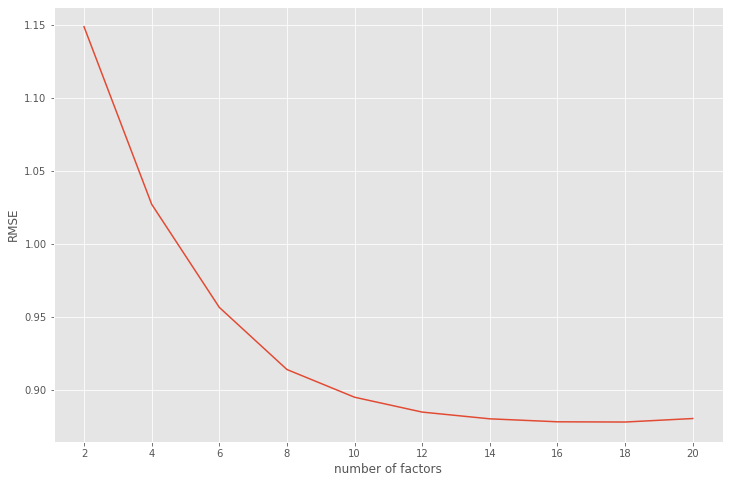

</center>

In [ ]:
best_n_factors = 18

> ### 3) Third, After choosing the best number of factors (minimum RMSE) we can build our model and start fitting the data.

In [ ]:
algo = NMF(n_factors=best_n_factors, random_state=0)
algo.fit(data.build_full_trainset())

> ### 4) Finally, We can use the model to predict the movie rating with **predict** method which takes two inputs **userid** and **movie id**.

In [ ]:
pred = algo.predict(vip_user_id, UNSEEN_MOVIE_IDS[0]).est
round(pred*2)/2

3.0

# **Construct movie-rating prediction function**

In [ ]:
def predict_movie_rating(user_id, movie_id=None, movie_title=None):
    """
    Predict rating of a movie based on userId and movieId or movieTitle.

    Parameters
    ----------
    user_id: int
        Represents the id of the user to be used in the function.

    movie_id: int, default= None
        Represents the id of the movie to be used in the function.

    movie_title: str, default= None
        Represents the title of the movie to be used in the function if movie_id is not entered.

    Returns
    -------
    alert_1, alert_2, result: str
        Describes the status of the output of prediction.
        alert_1: when user had seen that movie, alert_2: when there are no inputs about movie and result: otherwise
    """

    UNIQUE_MOVIE_IDS_USER = np.unique(final_df.loc[final_df.userId == user_id, 'movieId'])
    UNSEEN_MOVIE_IDS = np.setdiff1d(UNIQUE_MOVIE_IDS_TOTAL, UNIQUE_MOVIE_IDS_USER)
    alert_1 = f"Can't predict rating, Suggested Ids: {UNSEEN_MOVIE_IDS[:5]}"
    alert_2 = f"Can't predict rating, please insert inputs"

    if not movie_id and movie_title:
      movie_id = movies_df[movies_df.title == movie_title]['movieId'].values[0]
    elif not movie_id and not movie_title:
      return alert_2
    
    if movie_id in UNSEEN_MOVIE_IDS:
      algo = NMF(n_factors=best_n_factors, random_state=0)
      algo.fit(data.build_full_trainset())
      pred = algo.predict(user_id, movie_id).est
      movie_rate = round(pred*2)/2
      movie_title = movies_df[movies_df.movieId == movie_id]['title'].values[0]
    else:
      return alert_1
    
    result = f'UserId: {user_id}, MovieId: {movie_id}, MovieTitle: {movie_title}, Rating: {movie_rate}'
    return result

## - Predicting without inputs about the movie

In [ ]:
predict_movie_rating(vip_user_id)

"Can't predict rating, please insert inputs"

## - Predicting with a **movieId** that the user **has seen before**

In [ ]:
predict_movie_rating(vip_user_id, movie_id=200)

"Can't predict rating, Suggested Ids: [ 9 12 14 19 20]"

## - Predicting with a **movieId** that the user **has not seen before**

In [ ]:
predict_movie_rating(vip_user_id, movie_id=20)

'UserId: 414, MovieId: 20, MovieTitle: Money Train (1995), Rating: 3.0'

## - Predicting with a **movieTitle**

In [ ]:
predict_movie_rating(vip_user_id, movie_title='Money Train (1995)')

'UserId: 414, MovieId: 20, MovieTitle: Money Train (1995), Rating: 3.0'

### It's obvious that **`Recommender systems`** are a very powerful technology that can be used for extracting additional value for a business from its user databases. These systems help users find items they want to buy from a business. Recommender systems benefit users by enabling them to find items they like.